#**Imports**

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np


from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

#**Dataset**

In [146]:
df_train = pd.read_csv("Dataset/housing_coursework_train.csv", encoding="ISO-8859-1")
df_test = pd.read_csv("Dataset/housing_coursework_test.csv", encoding="ISO-8859-1")


In [147]:
df_train.head(10)

,No.,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,1,-122.21,37.83,34,5065,788.0,1627,766,6.8976,333300,NEAR BAY
1,2,-122.22,37.77,52,391,128.0,520,138,1.6471,95000,NEAR BAY
2,3,-122.23,37.79,30,610,145.0,425,140,1.6198,122700,NEAR BAY
3,4,-122.20,37.78,52,2300,443.0,1225,423,3.5398,158400,NEAR BAY
4,5,-122.19,37.79,50,954,217.0,546,201,2.6667,172800,NEAR BAY
5,6,-122.19,37.76,26,1293,297.0,984,303,1.9479,85800,NEAR BAY
6,7,-122.17,37.74,43,818,193.0,494,179,2.4776,101600,NEAR BAY
7,8,-122.18,37.75,46,941,218.0,621,195,1.3250,87100,NEAR BAY
8,9,-122.16,37.75,38,2457,624.0,1516,482,1.5625,91700,NEAR BAY
9,10,-122.14,37.75,33,1334,200.0,579,202,6.8323,255900,NEAR BAY


In [148]:
def scatter_plot(feature, target):
    plt.figure(figsize=(8, 4))
    plt.scatter(
        df_train[feature],
        df_train[target],
        c='black'
    )
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.show()

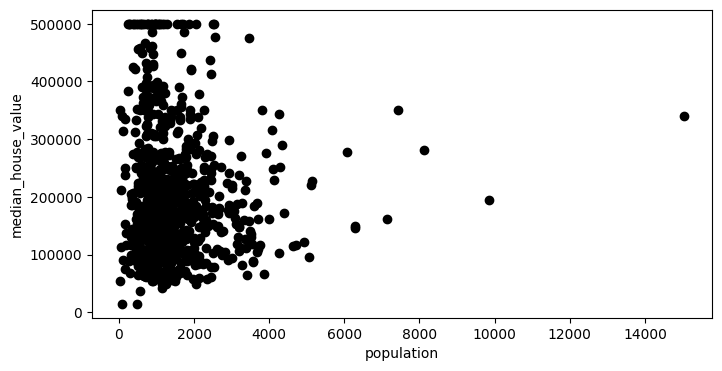

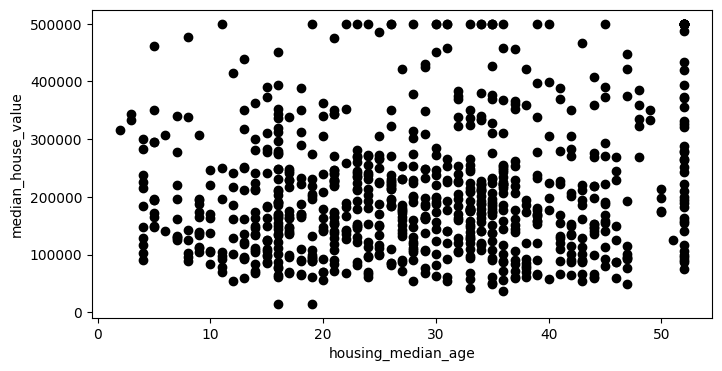

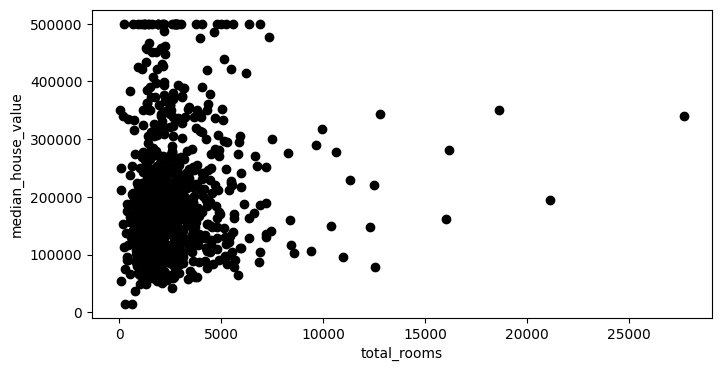

In [149]:
#Attempting to identifying linear relations
scatter_plot('population', 'median_house_value')
scatter_plot('housing_median_age', 'median_house_value')
scatter_plot('total_rooms', 'median_house_value')


#**Preprocessing**

In [150]:
#Detecting NaN vaues
print("Trainin set: \n",df_train.loc[df_train.isnull().any(axis=1)])
print("Test set: \n",df_test.loc[df_test.isnull().any(axis=1)])

Trainin set: 
      No.  longitude  latitude  housing_median_age  total_rooms  \
72    73    -122.08     37.88                  26         2947   
168  169    -118.28     34.25                  29         2559   
236  237    -118.38     34.05                  49          702   
548  549    -117.87     33.83                  27         2287   
621  622    -116.21     33.75                  22          894   
740  741    -117.02     32.66                  19          771   
786  787    -122.45     37.77                  52         2602   
792  793    -122.50     37.75                  45         1620   

     total_bedrooms  population  households  median_income  \
72              NaN         825         626         2.9330   
168             NaN        1886         769         2.6036   
236             NaN         458         187         4.8958   
548             NaN        1140         351         5.6163   
621             NaN         830         202         3.0673   
740             Na

In [151]:
#Filling Nan total_bedrooms data points with the average total_bedrooms to dampen their effect.
average_total_bedrooms = df_train['total_bedrooms'].mean()
df_train.loc[df_train['total_bedrooms'].isnull(),'total_bedrooms'] = average_total_bedrooms

average_total_bedrooms = df_test['total_bedrooms'].mean()
df_test.loc[df_test['total_bedrooms'].isnull(),'total_bedrooms'] = average_total_bedrooms

In [152]:
#Shuffle dataset
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.head(10)

df_test = df_test.sample(frac=1).reset_index(drop=True)
df_test.head(10)


,No.,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,981,-119.23,36.39,39,1660,349.0,1061,306,1.4812,53500,INLAND
1,816,-121.12,37.73,35,1107,227.0,573,210,2.3924,102200,INLAND
2,891,-122.04,37.37,23,5135,911.0,2351,863,5.2319,430100,<1H OCEAN
3,1019,-122.03,38.69,23,1796,380.0,939,330,2.7955,96300,INLAND
4,861,-121.87,37.28,21,3305,749.0,2459,701,3.9688,249600,<1H OCEAN
5,984,-119.29,36.34,35,1235,369.0,1246,341,1.4740,71000,INLAND
6,989,-119.31,36.31,18,3860,760.0,1643,664,2.0714,92600,INLAND
7,935,-122.68,38.36,8,7520,1336.0,3833,1287,4.3278,184100,<1H OCEAN
8,876,-121.96,37.39,20,1032,229.0,658,238,4.5062,219300,<1H OCEAN
9,845,-120.40,34.95,8,1885,286.0,835,290,5.0206,261000,<1H OCEAN


In [153]:
# Integer encoding ocean proximity
df_train['ocean_proximity']=np.where(df_train['ocean_proximity'] == 'INLAND', 0,
                            np.where(df_train['ocean_proximity'] == '<1H OCEAN', 1,
                            np.where(df_train['ocean_proximity'] == 'NEAR OCEAN', 2,
                            np.where(df_train['ocean_proximity'] == 'NEAR BAY', 3 , df_train['ocean_proximity']))))

df_test['ocean_proximity']=np.where(df_test['ocean_proximity'] == 'INLAND', 0,
                            np.where(df_test['ocean_proximity'] == '<1H OCEAN', 1,
                            np.where(df_test['ocean_proximity'] == 'NEAR OCEAN', 2,
                            np.where(df_test['ocean_proximity'] == 'NEAR BAY', 3 , df_test['ocean_proximity']))))                           
df_train.head(10)

,No.,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,395,-118.13,33.78,31,3039,739.0,1199,697,3.7232,500001,2
1,413,-118.31,33.91,31,1415,339.0,874,289,3.8173,177900,1
2,229,-118.31,34.08,49,2549,630.0,1539,594,2.6218,350900,1
3,323,-118.03,34.16,39,2731,366.0,1034,338,9.8098,500001,0
4,468,-122.53,37.92,45,1530,324.0,608,328,3.8750,390800,3
5,327,-118.06,34.10,42,1576,313.0,697,282,4.3523,283600,1
6,499,-117.89,33.92,34,1473,312.0,1025,315,3.8333,170400,1
7,44,-121.87,37.67,10,4337,800.0,1813,743,5.5000,247200,0
8,601,-117.44,33.90,23,4487,754.0,2609,778,4.2788,148700,0
9,328,-118.07,34.09,40,1745,370.0,1293,357,2.5474,198100,1


In [154]:
# Dropping unnecessary columns
df_train= df_train.drop(columns=['No.'])


df_test = df_test.drop(columns=['No.'])

df_train.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-118.13,33.78,31,3039,739.0,1199,697,3.7232,500001,2
1,-118.31,33.91,31,1415,339.0,874,289,3.8173,177900,1
2,-118.31,34.08,49,2549,630.0,1539,594,2.6218,350900,1
3,-118.03,34.16,39,2731,366.0,1034,338,9.8098,500001,0
4,-122.53,37.92,45,1530,324.0,608,328,3.8750,390800,3
5,-118.06,34.10,42,1576,313.0,697,282,4.3523,283600,1
6,-117.89,33.92,34,1473,312.0,1025,315,3.8333,170400,1
7,-121.87,37.67,10,4337,800.0,1813,743,5.5000,247200,0
8,-117.44,33.90,23,4487,754.0,2609,778,4.2788,148700,0
9,-118.07,34.09,40,1745,370.0,1293,357,2.5474,198100,1


#**Train**

In [155]:
#Splitting the data
X_train= df_train.drop(columns=['median_house_value'])

y_train= df_train['median_house_value']

X_test= df_test.drop(columns=['median_house_value'])
y_test= df_test['median_house_value']

#**Tuning**

In [182]:
# Trial and error tuning through GridSearch

parameters = {'alpha': [0, 0.1, 0.2, 0.3 ,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
lasso_grid = GridSearchCV(Lasso(), parameters,refit=True,verbose=3)
lasso_grid.fit(X_train,y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END ...........................alpha=0;, score=0.635 total time=   0.0s
[CV 2/5] END ...........................alpha=0;, score=0.512 total time=   0.0s
[CV 3/5] END ...........................alpha=0;, score=0.560 total time=   0.0s
[CV 4/5] END ...........................alpha=0;, score=0.537 total time=   0.0s
[CV 5/5] END ...........................alpha=0;, score=0.640 total time=   0.0s
[CV 1/5] END .........................alpha=0.1;, score=0.635 total time=   0.0s
[CV 2/5] END .........................alpha=0.1;, score=0.512 total time=   0.0s
[CV 3/5] END .........................alpha=0.1;, score=0.560 total time=   0.0s
[CV 4/5] END .........................alpha=0.1;, score=0.537 total time=   0.0s
[CV 5/5] END .........................alpha=0.1;, score=0.640 total time=   0.0s
[CV 1/5] END .........................alpha=0.2;, score=0.635 total time=   0.0s
[CV 2/5] END .........................alpha=0.2;

s:\Personal\Active Projects\Uni Projects\Year 3\ML\env\lib\site-packages\sklearn\model_selection\_validation.py:686: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
s:\Personal\Active Projects\Uni Projects\Year 3\ML\env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
s:\Personal\Active Projects\Uni Projects\Year 3\ML\env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.544e+12, tolerance: 7.683e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted usin

[CV 2/5] END .........................alpha=0.5;, score=0.512 total time=   0.0s
[CV 3/5] END .........................alpha=0.5;, score=0.560 total time=   0.0s
[CV 4/5] END .........................alpha=0.5;, score=0.537 total time=   0.0s
[CV 5/5] END .........................alpha=0.5;, score=0.640 total time=   0.0s
[CV 1/5] END .........................alpha=0.6;, score=0.635 total time=   0.0s
[CV 2/5] END .........................alpha=0.6;, score=0.512 total time=   0.0s
[CV 3/5] END .........................alpha=0.6;, score=0.560 total time=   0.0s
[CV 4/5] END .........................alpha=0.6;, score=0.537 total time=   0.0s
[CV 5/5] END .........................alpha=0.6;, score=0.640 total time=   0.0s
[CV 1/5] END .........................alpha=0.7;, score=0.635 total time=   0.0s
[CV 2/5] END .........................alpha=0.7;, score=0.512 total time=   0.0s
[CV 3/5] END .........................alpha=0.7;, score=0.560 total time=   0.0s
[CV 4/5] END ...............

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                   0.9, 1]},
             verbose=3)

In [183]:
print("Best parameters:", lasso_grid.best_params_)
print("Accuracy:", lasso_grid.score(X_test,y_test))
lasso_grid.cv_results_

Best parameters: {'alpha': 1}
Accuracy: 0.7086991812701698


{'mean_fit_time': array([0.00760875, 0.00680771, 0.00460134, 0.00520406, 0.00480585,
        0.00480423, 0.00460615, 0.0042006 , 0.00540481, 0.00400348,
        0.00460238]),
 'std_fit_time': array([1.35662539e-03, 1.47031604e-03, 4.91237090e-04, 9.80571955e-04,
        4.01173714e-04, 4.00114187e-04, 8.00029898e-04, 3.98096537e-04,
        1.02082415e-03, 1.78416128e-07, 8.00526619e-04]),
 'mean_score_time': array([0.00179954, 0.00220075, 0.0014039 , 0.00200338, 0.00159993,
        0.00160155, 0.00139942, 0.00119824, 0.00160155, 0.00120263,
        0.00180259]),
 'std_score_time': array([0.00074807, 0.00116881, 0.00049399, 0.00063218, 0.00048884,
        0.00049035, 0.0004888 , 0.00040201, 0.00049035, 0.00039958,
        0.00074907]),
 'param_alpha': masked_array(data=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False],
        fill_value='?',
             dtype=object

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


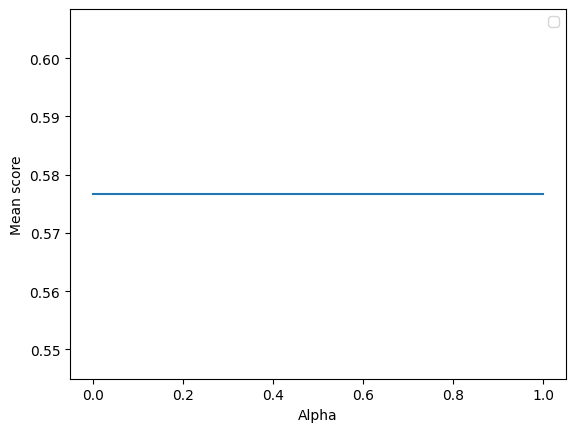

In [188]:
# scores = [x[1] for x in lasso_grid.cv_results_['mean_test_score']]
# scores = np.array(scores).reshape(len(parameters['alpha']))

# for ind, i in enumerate(parameters['alpha']):
#     plt.plot(scores[ind], label='C: ' + str(i))
plt.plot(parameters['alpha'], np.round(lasso_grid.cv_results_['mean_test_score'],4))
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean score')
plt.show()

#**Training with tuned parameters**

In [189]:
best_alpha = lasso_grid.best_params_['alpha']
tuned_lasso= Lasso(alpha=best_alpha)

In [190]:
tuned_lasso.fit(X_train,y_train)

Lasso(alpha=1)

#**Final Test**

In [191]:
y_pred_SVM= tuned_lasso.predict(X_test)
print(r2_score(y_test, y_pred_SVM))

0.7086991812701698


#**Persistence**

In [140]:
#Save model to disk
filepath = './models/basemodel.sav'
pickle.dump(tuned_lasso, open(filepath, 'wb'))

In [141]:
#Load saved model from disk
loaded_model = pickle.load(open(filepath, 'rb'))
result = loaded_model.score(X_test, y_test)

In [142]:
y_pred_SVM= loaded_model.predict(X_test)
print(r2_score(y_test, y_pred_SVM))

0.708687670290512
